# Automated doubly robust estimation with ChiRho

In [1]:
import collections
import math
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Dict

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from pyro.infer import Predictive
from typing import Callable, Dict, List, Optional, Tuple, Union

from chirho.robust import one_step_correction
from chirho.robust.ops import DataConditionedModel
from chirho.robust.functionals import average_treatment_effect

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

# Probabilistic model for the data generating process

In [2]:
class HighDimLinearModel(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: float = None,
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        loc = pyro.sample(
            "covariate_loc", dist.Normal(0.0, 1.0).expand((self.p,)).to_event(1)
        )
        scale = pyro.sample(
            "covariate_scale", dist.LogNormal(0, 1).expand((self.p,)).to_event(1)
        )
        return loc, scale

    def forward(self, N: int):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        with pyro.plate("obs", N, dim=-1):
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
            A = pyro.sample(
                "A",
                dist.Bernoulli(
                    logits=torch.einsum("...np,...p->...n", X, propensity_weights)
                ),
            )
            return pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("...np,...p->...n", X, outcome_weights)
                    + A * tau
                    + intercept
                ),
            )


class KnownCovariateDistModel(HighDimLinearModel):
    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)


class BenchmarkLinearModel(HighDimLinearModel):
    def __init__(
        self,
        p: int,
        link_fn: Callable,
        alpha: int,
        beta: int,
        treatment_weight: float = 0.0,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparisty of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_treatment_null_weight(self):
        return torch.tensor(0.0)

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_treatment_null_weight(self):
        return torch.tensor(0.0)

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)

# Closed-form influence function for average treatment effect

In [3]:
# Traditional ATE correction based on analytic derivation (see, for example, Kennedy (2023))
def closed_form_ate_correction(X_test, theta):
    X = X_test["X"]
    A = X_test["A"]
    Y = X_test["Y"]
    pi_X = torch.sigmoid(X.mv(theta["propensity_weights"]))
    mu_X = X.mv(theta["outcome_weights"]) + A * theta["treatment_weight"] + theta["intercept"]
    analytic_eif_at_test_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
    analytic_correction = analytic_eif_at_test_pts.mean()
    return analytic_correction, analytic_eif_at_test_pts

# Approximation quality of monte carlo influence function vs. analytical influence function

In [9]:
p = 1
alpha = 1
beta = 1
N_train = 10
N_test = 100
link = lambda mu: dist.Normal(mu, 1.0)

pyro.clear_param_store()

# Generate data
benchmark_model = BenchmarkLinearModel(p, link, alpha, beta)

with pyro.poutine.trace() as train_tr:
    benchmark_model(N=N_train)

with pyro.poutine.trace() as test_tr:
    benchmark_model(N=N_test)

D_train = {k: train_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}
D_test = {k: test_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}

model = KnownCovariateDistModel(p, link)
conditioned_model = DataConditionedModel(model)
guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

# initialize parameters
elbo(D_train)

adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

# Do gradient steps
for step in range(2000):
    adam.zero_grad()
    loss = elbo(D_train)
    loss.backward()
    adam.step()

theta_hat = {k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()}
analytic_correction, analytic_eif_at_test_pts = closed_form_ate_correction(D_test, theta_hat)

# Compute ATE correction using ChiRho's autodiff + Monte Carlo algorithm
ATE_plugin = average_treatment_effect(model, theta_hat, n_monte_carlo=10000)
N_monte_carlo_grid = [10 * p, 100 * p, 1000 * p, 10000 * p, 25000 * p]
relative_errors = []
absolute_errors = []
monte_correction = []
actual_correction = []
signed_relative_errors = []


for N_monte_carlo in N_monte_carlo_grid:
    print(f"N_monte_carlo = {N_monte_carlo}")
    ATE_correction = one_step_correction(
        model,
        theta_hat,
        average_treatment_effect,
        D_test,
        pointwise_influence = True,
        n_monte_carlo=N_monte_carlo,
    )

    relative_errors.append(((ATE_correction - analytic_eif_at_test_pts) / analytic_eif_at_test_pts).abs())
    signed_relative_errors.append(((ATE_correction - analytic_eif_at_test_pts) / analytic_eif_at_test_pts))
    absolute_errors.append((ATE_correction - analytic_eif_at_test_pts).abs())
    monte_correction.append(ATE_correction)
    actual_correction.append(analytic_eif_at_test_pts)

N_monte_carlo = 10
N_monte_carlo = 100
N_monte_carlo = 1000
N_monte_carlo = 10000
N_monte_carlo = 25000


Text(0.5, 0, '# Monte Carlo samples')

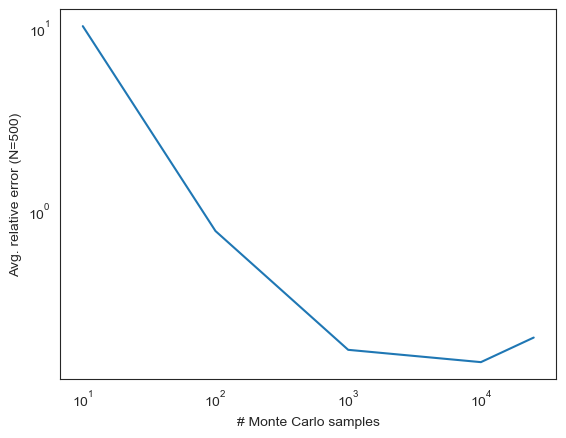

In [10]:
avg_relative_errors = [relative_errors[i].mean().item() for i in range(len(N_monte_carlo_grid))]
plt.plot(N_monte_carlo_grid, avg_relative_errors)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Avg. relative error (N=500)")
plt.xlabel("# Monte Carlo samples")

Text(0.5, 0, 'Monte Carlo EIF correction')

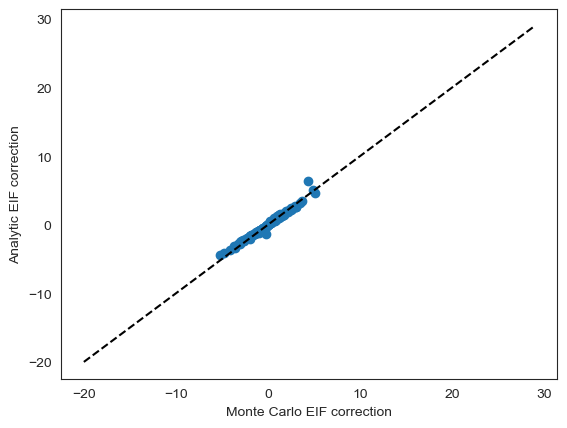

In [11]:
import numpy as np
plt.scatter(monte_correction[-1].detach().numpy(), actual_correction[-1].detach().numpy())
plt.plot(np.arange(-20, 30), np.arange(-20, 30), linestyle="--", color='black')
plt.ylabel("Analytic EIF correction")
plt.xlabel("Monte Carlo EIF correction")

# Empirical evaluation

In [9]:
# Since we have access to the true data-generating distribution, we
# can keep simulating new datasets and retraining the model to get the 
# sampling distribution of each estimator. In practice, one would need to 
# use bootstrapping to approximate the true sampling distribution.

N_runs = 100
plug_in_estimates = []
one_step_correction_monte_carlo = []
one_step_correction_analytic = []

p = 200
alpha = 50
beta = 50
N_train = 500
N_test = 500

link = gaussian_link

for i in range(N_runs):
    pyro.clear_param_store()

    # Generate data
    benchmark_model = BenchmarkLinearModel(p, link, alpha, beta)

    with pyro.poutine.trace() as train_tr:
        benchmark_model(N=N_train)

    with pyro.poutine.trace() as test_tr:
        benchmark_model(N=N_test)

    D_train = {k: train_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}
    D_test = {k: test_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}


    print(f"Run {i}/{N_runs}")
    conditioned_model = ConditionedModel(p, link)
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo(D_train)

    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for step in range(2000):
        adam.zero_grad()
        loss = elbo(D_train)
        loss.backward()
        adam.step()
        # if step % 250 == 0:
        #     print("[iteration %04d] loss: %.4f" % (step, loss))
    theta_hat = {k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()}
    # print(theta_hat.keys(), theta_hat["treatment_weight"])

    unconditioned_model = KnownCovariateDistModel(p, link, prior_scale=1.)
    model_cond_theta = condition(data=theta_hat)(unconditioned_model)

    ATE_plugin = ATE(model_cond_theta, num_samples=10000)
    # # print("ATE plugin", ATE_plugin)

    ATE_correction = one_step_correction(
        lambda m: ATE(m, num_samples=1000),
        unconditioned_model,
        conditioned_model,
        ["X", "A", "Y"],
        theta_hat,
        D_test,
        eps_fisher=0.0,
        N_monte_carlo=100*p
    )
    ATE_onestep = ATE_plugin + ATE_correction
    # # print(ATE_plugin, ATE_correction, ATE_onestep)

    analytic_correction, analytic_eif_at_test_pts = closed_form_ate_correction(D_test, theta_hat)

    plug_in_estimates.append(ATE_plugin.item())
    one_step_correction_monte_carlo.append(ATE_correction.item())
    one_step_correction_analytic.append(analytic_correction.item())

plug_in_estimates = torch.tensor(plug_in_estimates)
one_step_correction_monte_carlo = torch.tensor(one_step_correction_monte_carlo)
one_step_correction_analytic = torch.tensor(one_step_correction_analytic)

Run 0/100
Run 1/100
Run 2/100
Run 3/100
Run 4/100
Run 5/100
Run 6/100
Run 7/100
Run 8/100
Run 9/100
Run 10/100
Run 11/100
Run 12/100
Run 13/100
Run 14/100
Run 15/100
Run 16/100
Run 17/100
Run 18/100
Run 19/100
Run 20/100
Run 21/100
Run 22/100
Run 23/100
Run 24/100
Run 25/100
Run 26/100
Run 27/100
Run 28/100
Run 29/100
Run 30/100
Run 31/100
Run 32/100
Run 33/100
Run 34/100
Run 35/100
Run 36/100
Run 37/100
Run 38/100
Run 39/100
Run 40/100
Run 41/100
Run 42/100
Run 43/100
Run 44/100
Run 45/100
Run 46/100
Run 47/100
Run 48/100
Run 49/100
Run 50/100
Run 51/100
Run 52/100
Run 53/100
Run 54/100
Run 55/100
Run 56/100
Run 57/100
Run 58/100
Run 59/100
Run 60/100
Run 61/100
Run 62/100
Run 63/100
Run 64/100
Run 65/100
Run 66/100
Run 67/100
Run 68/100
Run 69/100
Run 70/100
Run 71/100
Run 72/100
Run 73/100
Run 74/100
Run 75/100
Run 76/100
Run 77/100
Run 78/100
Run 79/100
Run 80/100
Run 81/100
Run 82/100
Run 83/100
Run 84/100
Run 85/100
Run 86/100
Run 87/100
Run 88/100
Run 89/100
Run 90/100
Run 91/10

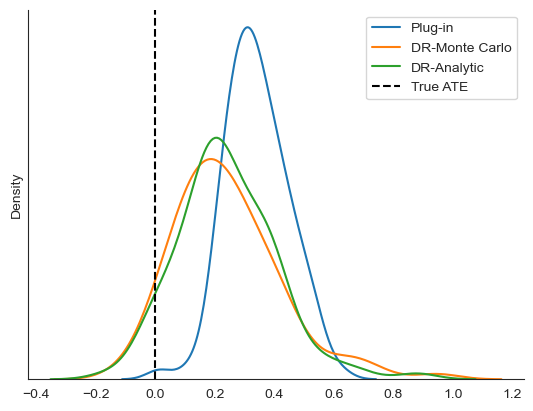

In [11]:
fig, ax = plt.subplots()

sns.kdeplot(
    plug_in_estimates, 
    label="Plug-in", ax=ax
)

sns.kdeplot(
    plug_in_estimates + one_step_correction_monte_carlo, 
    label="DR-Monte Carlo", ax=ax
)

sns.kdeplot(
    plug_in_estimates + one_step_correction_analytic, 
    label="DR-Analytic", ax=ax
)

ax.axvline(0, color="black", label="True ATE", linestyle="--")
ax.set_yticks([])
sns.despine()
ax.legend(loc="upper right")